# LightBGMによるモデリング

決定木系の機械学習法。　

## 機械学習手法の分類

- 学習手法
    - 決定木
        - ランダムフォレスト
            - 決定木を複数作成して組み合わせる方法。
        - Gradient Boosting Decision Tree
            - 決定木を逐次的に更新していく方法
                - LightGBM
                - XGBoost
    - ニューラルネットワーク
    - etc

## 過学習と学習不足

予測タスクにおける機械学習は、学習データから目的変数に対する説明変数のモデルを作成し、テストデータに適用するもの。

既知のデータに過剰に適用しすぎると、未知のデータに対する精度が下がる可能性がある。これを過学習という。
学習が不十分であれば、学習不足という。

過学習を避ける範囲で学習を止めるチューニングをすることが機械学習において肝要となる。

## チューニング方法

過学習をさけるために学習データから検証データを分離する方法。

- ホールドアウト
    - 一定比率で学習データと検証データを分ける方法。
    - 検証データに対する精度を見ながらモデルの学習を進める場合、検証データでの予測に過度に適合してしまう可能性がある。
- クロスバリデーション
    - ある程度データがある場合に向いている。
    - データ全体を任意のブロックに分割しそのうち１つを検証データ、残りを学習データとすることを分割個数分繰り返す方法。
- ジャックナイフ法
    - データが少ない場合に向いている。
    - 全テストデータのうち１つを検証データとし、残りを学習データとすることを全データ分繰り返す方法。

## ホールドアウト、クロスバリデーションでチューニングする

In [19]:
import pandas as pd
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder


In [3]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

In [29]:
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)

## 欠損値を置き換える
## PclassごとのFareの平均値を計算
Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()
# 敬称を変数として追加する
name_df = all_df["Name"].str.split(pat="[,.]", n=2, expand=True)
name_df.columns = ["family_name", "honorific", "name"]
# 先頭と末尾の空白文字の削除
name_df["family_name"] = name_df["family_name"].str.strip()
name_df["honorific"] = name_df["honorific"].str.strip()
name_df["name"] = name_df["name"].str.strip()

## ２つのDataFrameを結合
all_df = pd.concat([all_df, name_df],axis=1)
# 敬称ごとの平均年齢で年齢が欠損しているデータを穴埋めする

honorific_age_mean = all_df[["honorific", "Age"]].groupby("honorific").mean().reset_index()
honorific_age_mean.columns = ["honorific", "honorific_Age"]

all_df = pd.merge(all_df, honorific_age_mean, on="honorific", how="left")
all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["honorific_Age"]
all_df = all_df.drop(["honorific_Age"],axis=1)
# 家族人数を追加する
all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]
all_df["family_num"].value_counts()
# 家族人数が0かどうかを表す変数を追加
all_df.loc[all_df["family_num"] ==0, "alone"] = 1
all_df["alone"].fillna(0, inplace=True)

target_columns = ["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"]

if all(col in all_df.columns for col in target_columns):
    all_df = all_df.drop(columns=["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)

all_df.loc[~(
    (all_df["honorific"] == "Mr") |
    (all_df["honorific"] == "Miss") |
    (all_df["honorific"] == "Mrs") |
    (all_df["honorific"] == "Master")),
"honorific"] = "other"

# Label Encoding

le = LabelEncoder()
le = le.fit(all_df["Sex"])
all_df["Sex"] = le.transform(all_df["Sex"])

categories = all_df.columns[all_df.dtypes == "object"]

for cat in categories:
    le = LabelEncoder()
    print(cat)
    if all_df[cat].dtypes == "object":
        le = le.fit(all_df[cat])
        all_df[cat] = le.transform(all_df[cat])

all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left")

Embarked
honorific


/var/folders/pt/v29l1vwx7c3_45d3f_v8knlm0000gn/T/ipykernel_15012/985456886.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df["alone"].fillna(0, inplace=True)


In [ ]:
train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
train_Y = train_df["Survived"]

In [31]:
# 学習データの20％を検証データの分割する

X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_Y, test_size=0.2)

In [32]:
# LightGBM用のデータセットを作成

categories = ["Embarked", "Pclass", "Sex", "honorific", "alone"]

lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categories)
lgb_eval = lgb.Dataset(X_train, y_train, categorical_feature=categories, reference=lgb_train)

In [33]:
# ハイパーパラメーターを設定する

lgbm_params = {
    "objective": "binary",
    "random_seed": 1234
}

In [ ]:
# LightGBMによる機械学習モデルを学習させる

model_lgb = lgb.train(
    lgbm_params,
    lgb_train,
    valid_sets=lgb_eval,
    num_boost_round=100,
    callbacks=[lgb.early_stopping(20), lgb.log_evaluation(period=10)]
    )

[LightGBM] [Info] Number of positive: 283, number of negative: 429
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 228
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.397472 -> initscore=-0.416010
[LightGBM] [Info] Start training from score -0.416010
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

In [35]:
# 各変数の重要度を調べる

model_lgb.feature_importance()

array([  99,   67, 1023,   61,   44, 1113,  135,   30,   88,   17,   18],
      dtype=int32)

<Axes: >

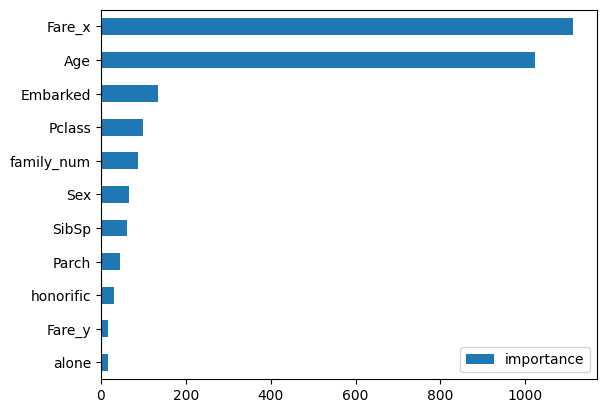

In [37]:
importance = pd.DataFrame(model_lgb.feature_importance(), index=X_train.columns, columns=["importance"]).sort_values(by="importance", ascending=True)
importance.plot.barh()

In [38]:
# モデルを検証でーたに適用する

y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)

## 予測精度を計測する



In [ ]:
## 